In [48]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.commands import SamplePulse

In [49]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 0 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data
scale_factor = 1e-14

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

Credentials are already in use. The existing account in the session will be replaced.


Qubit 0 has an estimated frequency of 4.97429139400153 GHz.


In [50]:
def get_closest_multiple_of_16(num):
    return (int(num) - (int(num)%16))

In [51]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.075                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

# Drive pulse samples
freq_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                 sigma=drive_sigma,
                                 amp=0.3,
                                 name='freq_sweep_excitation_pulse')

In [52]:
# Find out which group of qubits need to be acquired with this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [53]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

In [54]:
# Calculate amplitude from complex signal
# Takes in complex vector and returns real vector encoding the signal
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

In [55]:
# apparently np.c_ also does this (column stack)
def reshape_complex_vec(vec):
    '''Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        vec_reshaped (list): vector w/ entries given by (real(vec], imag(vec))
    '''
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i]=[np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

### 01 freq sweep

In [56]:
NUM_SHOTS = 512
# Returns freqs array and assembled freq_qobj
def create_ground_freq_sweep_program(qubit_freq, freq_step, freq_span):
    """
    Builds a qobj that does a freq sweep for the 0->1 transition.
    Args:
        num_freq (int): number of frequencies used
        freq_pm (float): plus/minus frequency range
        drive_power (float) : value of drive amplitude
        shots (int): number of shots over which to do the experiment
    Returns:
        freqs, freq_sweep_qobj (list, qobj): frequency list and qobj for freq sweep experiments
    """
    # construct frequency list
    freqs = qubit_freq + np.arange(-freq_span/2, freq_span/2, freq_step)
    
    print(f"The sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
in steps of {freq_step / MHz} MHz.")
    
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    schedule += freq_sweep_drive_pulse(drive_chan)
    schedule += measure << schedule.duration

    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble freq sweep qobj
    freq_sweep_program = assemble(schedule,
                               backend=backend, 
                               meas_level=1,
                               meas_return='avg',
                               shots=NUM_SHOTS,
                               schedule_los=schedule_freqs)
    
    return freqs, freq_sweep_program

In [57]:
# We will sweep 40 MHz around the estimated frequency
freq_span = 40 * MHz
# in steps of 1 MHz.
freq_step = 1 * MHz
sweep_freqs, freq_sweep_program = create_ground_freq_sweep_program(default_qubit_freq, freq_step, freq_span)

The sweep will go from 4.95429139400153 GHz to 4.993291394001529 GHz in steps of 1.0 MHz.


In [58]:
freq_sweep_job = backend.run(freq_sweep_program)

In [59]:
from qiskit.tools.monitor import job_monitor
job_monitor(freq_sweep_job)

Job Status: job has successfully run


In [110]:
def get_job_avg_data(job):
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        result_data.append(job_results.get_memory(i)[qubit]*scale_factor)  
    return result_data

In [112]:
def get_job_single_data(job):
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

In [111]:
freq_sweep_data = get_job_avg_data(freq_sweep_job)
#freq_sweep_data = get_amplitude(freq_sweep_data)

In [62]:
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [63]:
# do fit in GHz
fit_params, y_fit = fit_function(sweep_freqs/GHz,
                                 freq_sweep_data, 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [7, 4.975, 1, 3] # initial parameters for curve_fit
                                )

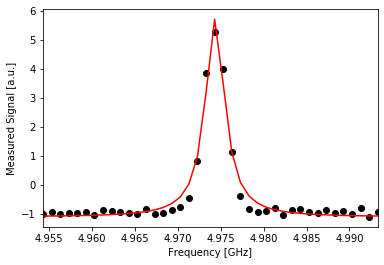

In [64]:
# Note: we are only plotting the real part of the signal
plt.scatter(sweep_freqs/GHz, freq_sweep_data, color='black')
plt.plot(sweep_freqs/GHz, y_fit, color='red')
plt.xlim([min(sweep_freqs/GHz), max(sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [71]:
_, cal_qubit_freq_GHz, _, _ = fit_params
cal_qubit_freq = cal_qubit_freq_GHz*GHz
print(f"We've updated our qubit frequency estimate from "
      f"{round(default_qubit_freq/GHz, 5)} GHz to {round(cal_qubit_freq/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.97429 GHz to 4.97434 GHz.


### 01 Rabi

In [66]:
# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [69]:
# Create schedule
rabi_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                    amp=drive_amp, 
                                    sigma=drive_sigma, 
                                    name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= rabi_pulse(drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_schedules.append(schedule)

In [72]:
# Assemble the schedules into a Qobj
rabi_expt_program = assemble(rabi_schedules,
                             backend=backend,
                             meas_level=1,
                             meas_return='avg',
                             shots=NUM_SHOTS,
                             schedule_los=[{drive_chan: cal_qubit_freq}]
                                            * num_rabi_points)

In [73]:
# print(job.job_id())
rabi_job = backend.run(rabi_expt_program)
job_monitor(rabi_job)

NameError: name 'job_rabi' is not defined

In [74]:
rabi_data = get_job_data(rabi_job)

In [75]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

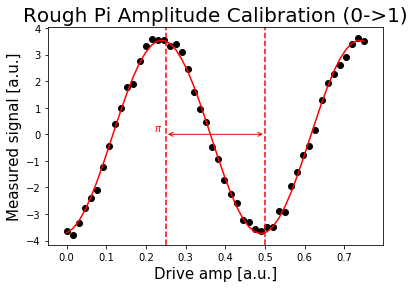

In [80]:
rabi_data = np.real(baseline_remove(rabi_data))
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_data, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [4, -4, 0.5, 0])

plt.scatter(drive_amps, rabi_data, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('Rough Pi Amplitude Calibration (0->1)', fontsize=20)
plt.show()

In [82]:
pi_amp_01 = abs(drive_period / 2)
print(f"Pi Amplitude (0->1) = {pi_amp_01}")

Pi Amplitude (0->1) = 0.2500903698622795


In [83]:
pi_pulse_01 = pulse_lib.gaussian(duration=drive_samples,
                                 amp=pi_amp_01, 
                                 sigma=drive_sigma,
                                 name='pi_pulse_01')

In [84]:
# Create two schedules

# Ground state schedule
zero_schedule = pulse.Schedule(name="ground state")
zero_schedule += measure

# Excited state schedule
one_schedule = pulse.Schedule(name="excited state")
one_schedule += pi_pulse_01(drive_chan)  # We found this in Part 2A above
one_schedule += measure << one_schedule.duration

In [88]:
IQ_01_program = assemble([zero_schedule, one_schedule],
                          backend=backend,
                          meas_level=1,
                          meas_return='single',
                          shots=NUM_SHOTS,
                          schedule_los=[{drive_chan: cal_qubit_freq}] * 2)

In [89]:
# print(job.job_id())
IQ_01_job = backend.run(IQ_01_program)
job_monitor(IQ_01_job)

Job Status: job has successfully run


In [141]:
IQ_01_data = get_job_single_data(IQ_01_job)

In [142]:
zero_data = IQ_01_data[0]
one_data = IQ_01_data[1]

In [152]:
def IQ_01_plot(x_min, x_max, y_min, y_max):
    plt.figure(figsize=[4,4])
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    plt.scatter(np.real(zero_data), np.imag(zero_data), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

    # Plot a large dot for the average result of the 0 and 1 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    plt.scatter(np.real(mean_zero), np.imag(mean_zero), 
                s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
    plt.scatter(np.real(mean_one), np.imag(mean_one), 
                s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1 discrimination", fontsize=15)

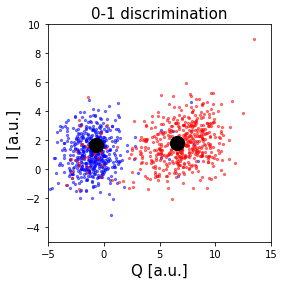

In [153]:
x_min = -5
x_max = 15
y_min = -5
y_max = 10
IQ_01_plot(x_min, x_max, y_min, y_max)

In [147]:
# Create IQ vector (split real, imag parts)
zero_data_reshaped = reshape_complex_vec(zero_data)
one_data_reshaped = reshape_complex_vec(one_data)  

IQ_01_data = np.concatenate((zero_data_reshaped, one_data_reshaped))
print(IQ_01_data.shape) # verify IQ data shape

# construct vector w/ 0's and 1's (for testing)
state = np.zeros(NUM_SHOTS) # shots gives number of experiments
state = np.concatenate((state, np.ones(NUM_SHOTS)))
print(len(state))

# Shuffle and split data into training and test sets
IQ_01_train, IQ_01_test, state_train, state_test = train_test_split(IQ_01_data, state, test_size=0.5)

(1024, 2)
1024


In [143]:
zero_data.shape

(512,)

In [128]:
np.concatenate((zero_data, one_data)).shape

(1024, 2)

In [131]:
# Set up the LDA
LDA = LinearDiscriminantAnalysis()
LDA.fit(IQ_01_train, state_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [132]:
# test on some simple data 
print(LDA.predict([[0,0], [10, 0]]))

[0. 1.]


In [134]:
# Compute accuracy
score = LDA.score(IQ_01_test, state_test)
print(score)

0.958984375


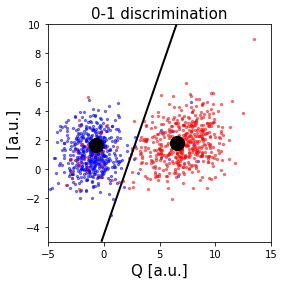

In [154]:
# Plot separatrix on top of scatter
def separatrixPlot(x_min, x_max, y_min, y_max, shots):
    nx, ny = shots, shots

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    Z = LDA.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)

    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')

x_min = -5
x_max = 15
y_min = -5
y_max = 10

IQ_01_plot(x_min, x_max, y_min, y_max)
separatrixPlot(x_min, x_max, y_min, y_max, NUM_SHOTS)